# Outgoing Kinematics Plotting
[uproot Getting Started](https://uproot.readthedocs.io/en/latest/basic.html)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot
import mplhep
import numpy as np
import dark_brem_lhe

plt.style.use(mplhep.style.ROOT)

## Data Loading and Manipulation
The `read` function is designed to import our data into a `pandas.DataFrame` and then add the higher-level kinematic variables.

Then we load our various data sets into memory, storing them into dictionaries with helpful names that could be used in plot legend.

In [2]:
def read(beam_E, fp) :
    """Read the passed file path into a dataframe one way or another
    
    Also calculate higher-level kinematic variables like recoil p_T,
    recoil lepton energy fraction, and recoil polar angle.
    
    If 'dblib' is in the file path, the `dark_brem_lhe` python module
    is used to parse the LHE file (if fp ends with '.lhe') or the directory
    of LHE files (otherwise) into the data frame.
    
    Otherwise, uproot is used to parse the ntuples at `dbint/dbint` into
    the data frame.
    """
    if 'dblib' in fp :
        if fp.endswith('.lhe') :
            df = dark_brem_lhe.DarkBremEventFile(fp).events
        else :
            df = dark_brem_lhe.DarkBremEventLibrary(fp).events()
    else :
        with uproot.open(fp) as f :
            df = f['dbint/dbint'].arrays(library='pd')
    df['recoil_pt'] = (df['recoil_px']**2 + df['recoil_py']**2)**(1/2)
    df['energy_frac'] = (df['recoil_energy'] - df['incident_mass'])/(df['incident_energy']-df['incident_mass'])
    df['recoil_angle'] = np.arctan2(df['recoil_pt'],df['recoil_pz'])
    df['visible_energy_frac'] = 1 - df['aprime_energy']/beam_E
    return df

In [3]:
version='v2.0.1-1-gebd9e9d'
el_data = {
    'MG' : read(4.,'../dblib/electron_tungsten_MaxE_4.0_MinE_0.2_RelEStep_0.1_UndecayedAP_mA_0.1_run_3000/electron_tungsten_MaxE_4.0_MinE_0.2_RelEStep_0.1_UndecayedAP_mA_0.1_run_3000_IncidentEnergy_4.0_unweighted_events.lhe'),
    'MG-Scaled' : read(4000.,f'../data/{version}/ntuple_electron_tungsten_depthmm_18.0_mAMeV_100_events_50000_run_3000.root'),
    'DMG4' : read(4000.,f'../data/{version}/ntuple_electron_tungsten_depthmm_18.0_mAMeV_100_events_50000_run_1.root'),
}
mu_data = {
    'MG' : read(100,'../dblib/muon_copper_MaxE_100.0_MinE_2.0_RelEStep_0.1_UndecayedAP_mA_1.0_run_3000/muon_copper_MaxE_100.0_MinE_2.0_RelEStep_0.1_UndecayedAP_mA_1.0_run_3000_IncidentEnergy_100.0_unweighted_events.lhe'),
    'MG-Scaled' : read(100105,f'../data/{version}/ntuple_muon_brass_depthmm_2000.0_mAMeV_1000_events_50000_run_3000.root'),
    'DMG4' : read(100105,f'../data/{version}/ntuple_muon_brass_depthmm_2000.0_mAMeV_1000_events_50000_run_1.root')
}

# Data Plotting
There are many variables of interest to plot. This first set of plots is focusing on the distributions that will end up in the paper: recoil lepton kinetic energy fraction, and recoil lepton polar angle.

### Comments
- We are expecting DMG4 to do little if anything to have a realistic recoil angle distribution. Thus, the DMG4 distribution for those plots is expected to be non-physical.
- Comparing to pure MadGraph is complicated. Choosing to compare directly to simply the beam-energy MG leads to some difference in the distributions when the leptons are properly biased (electron case - left column) and the electron actually undergoing the dark brem does not have an energy close to the beam energy.

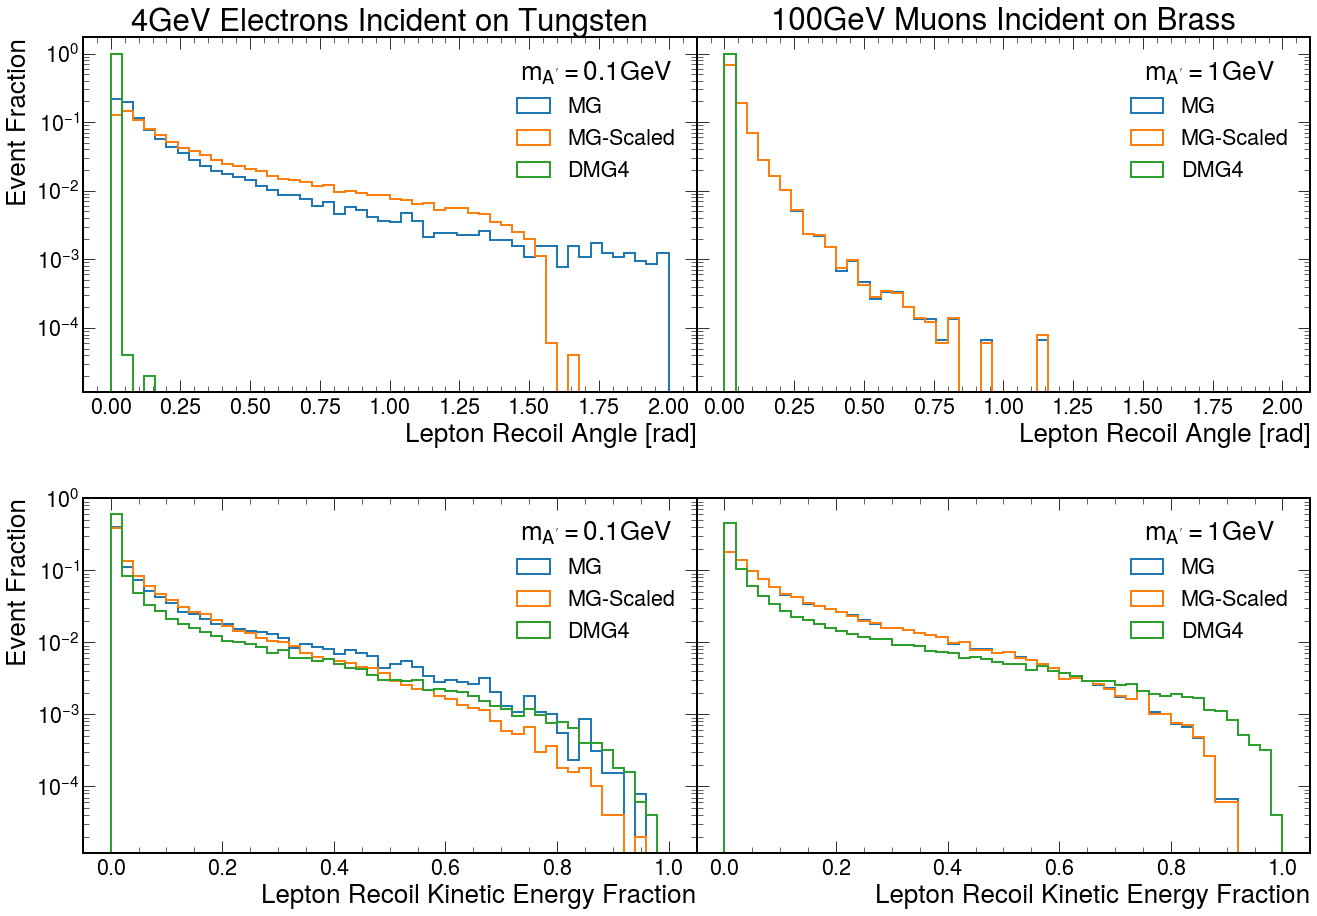

In [4]:
fig, ((e_ang,m_ang),(e_ke,m_ke)) = plt.subplots(ncols = 2, nrows = 2, sharey='row')
fig.set_size_inches(22,15)
plt.subplots_adjust(hspace=0.3, wspace=0.)

e_ang.set_xlabel('Lepton Recoil Angle [rad]')
e_ang.set_yscale('log')
e_ang.set_ylabel('Event Fraction')
e_ang.set_title('4GeV Electrons Incident on Tungsten')
for name, df in el_data.items() :
    e_ang.hist(df['recoil_angle'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
               label=name,linewidth=2.,
               histtype='step',range=(0.,2.),bins=50)
e_ang.legend(title='$m_{A\'}=0.1$GeV')

m_ang.set_xlabel('Lepton Recoil Angle [rad]')
m_ang.set_title('100GeV Muons Incident on Brass')
for name, df in mu_data.items() :
    m_ang.hist(df['recoil_angle'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
               label=name,linewidth=2.,
               histtype='step',range=(0.,2.0),bins=50)
m_ang.legend(title='$m_{A\'}=1$GeV')

e_ke.set_xlabel('Lepton Recoil Kinetic Energy Fraction')
e_ke.set_yscale('log')
e_ke.set_ylabel('Event Fraction')
for name, df in el_data.items() :
    e_ke.hist(df['energy_frac'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
              label=name,linewidth=2.,
               histtype='step',range=(0.,1.),bins=50)
e_ke.legend(title='$m_{A\'}=0.1$GeV')

m_ke.set_xlabel('Lepton Recoil Kinetic Energy Fraction')
for name, df in mu_data.items() :
    m_ke.hist(df['energy_frac'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
              label=name,linewidth=2.,
               histtype='step',range=(0.,1.),bins=50)
m_ke.legend(title='$m_{A\'}=1$GeV')

plt.show()

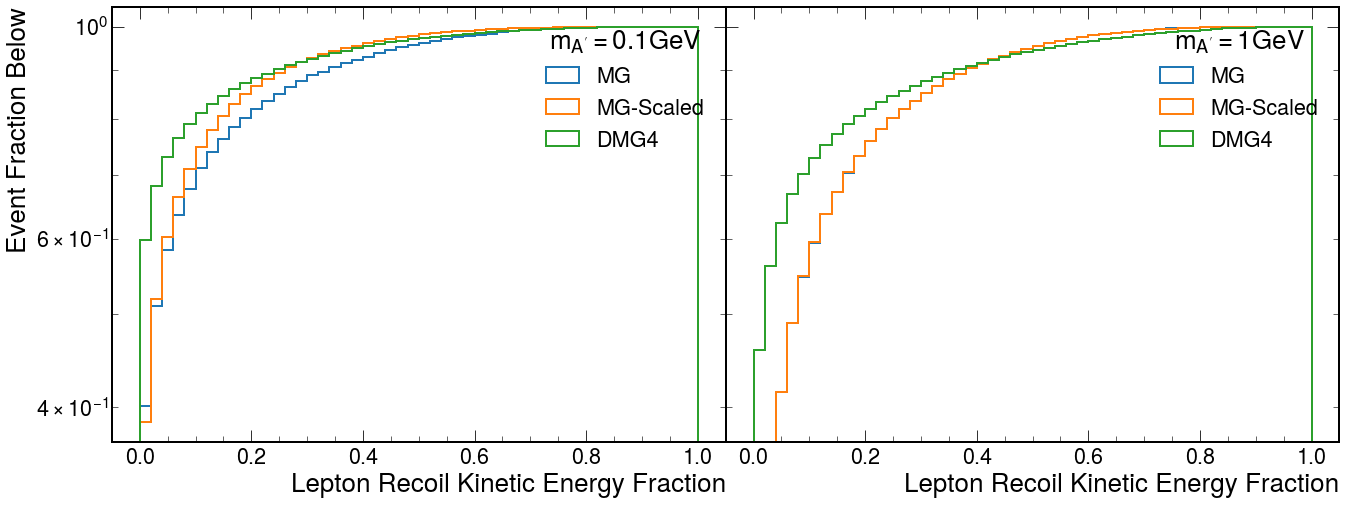

In [5]:
fig, ((e_ke_cm,m_ke_cm)) = plt.subplots(ncols = 2, nrows = 1, sharey='row')
fig.set_size_inches(22,8)
plt.subplots_adjust(hspace=0.3, wspace=0.)

e_ke_cm.set_xlabel('Lepton Recoil Kinetic Energy Fraction')
e_ke_cm.set_yscale('log')
e_ke_cm.set_ylabel('Event Fraction Below')
for name, df in el_data.items() :
    e_ke_cm.hist(df['energy_frac'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
                 label=name, cumulative=True, linewidth=2.,
               histtype='step',range=(0.,1.),bins=50)
e_ke_cm.legend(title='$m_{A\'}=0.1$GeV')

m_ke_cm.set_xlabel('Lepton Recoil Kinetic Energy Fraction')
for name, df in mu_data.items() :
    m_ke_cm.hist(df['energy_frac'],weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
                 label=name, cumulative=True,linewidth=2.,
                 histtype='step',range=(0.,1.),bins=50)
m_ke_cm.legend(title='$m_{A\'}=1$GeV')
      
plt.show()

## Visible Energy Fraction
As an actual observable, we can look at the fraction of the beam that is "visible" (all energy _not_ in the dark photon).

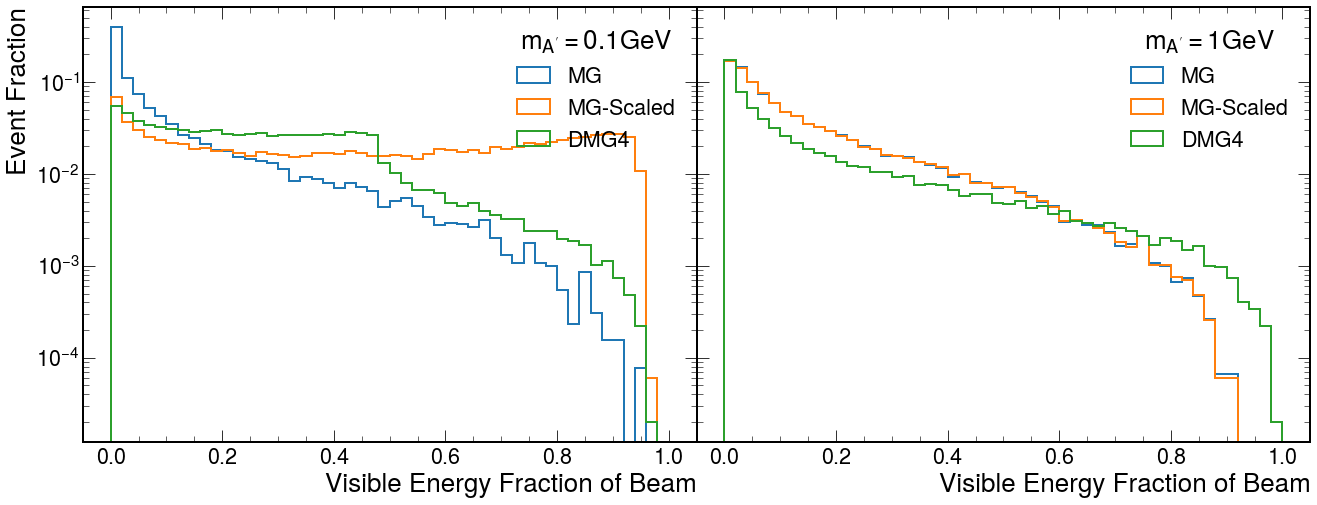

In [6]:
fig, ((e_ke_cm,m_ke_cm)) = plt.subplots(ncols = 2, nrows = 1, sharey='row')
fig.set_size_inches(22,8)
plt.subplots_adjust(hspace=0.3, wspace=0.)

e_ke_cm.set_xlabel('Visible Energy Fraction of Beam')
e_ke_cm.set_yscale('log')
e_ke_cm.set_ylabel('Event Fraction')
for name, df in el_data.items() :
    e_ke_cm.hist(df['visible_energy_frac'],weights=np.ones(len(df['visible_energy_frac']))/len(df['visible_energy_frac']),
                 label=name, linewidth=2.,
               histtype='step',range=(0.,1.),bins=50)
e_ke_cm.legend(title='$m_{A\'}=0.1$GeV')

m_ke_cm.set_xlabel('Visible Energy Fraction of Beam')
for name, df in mu_data.items() :
    m_ke_cm.hist(df['visible_energy_frac'],weights=np.ones(len(df['visible_energy_frac']))/len(df['visible_energy_frac']),
                 label=name, linewidth=2.,
                 histtype='step',range=(0.,1.),bins=50)
m_ke_cm.legend(title='$m_{A\'}=1$GeV')
      
plt.show()

## Incident Lepton Energy
This is a helpful cross check to make sure that the G4-based simulation is actually having leptons of various energies undergo a dark brem.

As can been seen right now, currently, only the MGS-electron case is properly biased so as to have a variety of incident energies.

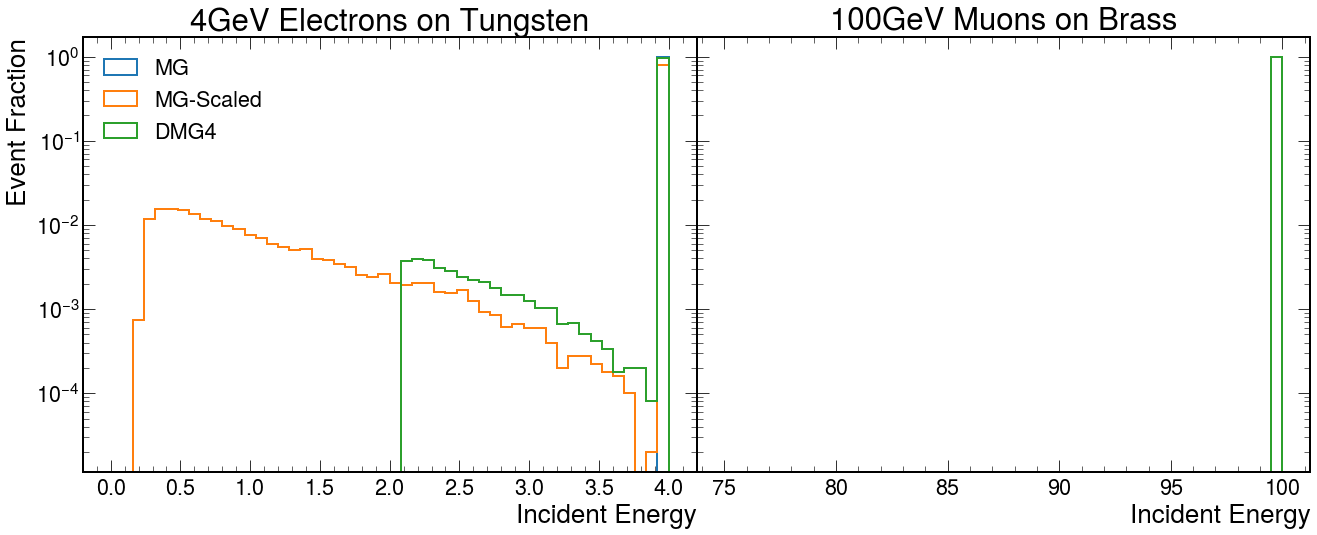

In [7]:
fig, ((e,m)) = plt.subplots(ncols=2,nrows=1,sharey=True)
fig.set_size_inches(22,8)
plt.subplots_adjust(hspace=0.3,wspace=0.)
e.set_title('4GeV Electrons on Tungsten')
e.set_xlabel('Incident Energy')
e.set_yscale('log')
e.set_ylabel('Event Fraction')
for name, df in el_data.items() :
    MeV_to_GeV = 1.
    shift = 0.
    if name != 'MG' :
        MeV_to_GeV = 1./1000
        shift = 0.511 #MeV
    e.hist((df['incident_energy']-shift)*MeV_to_GeV,weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
                 label=name,linewidth=2., histtype='step',range=(0.,4.),bins=50)
e.legend(loc='upper left')

m.set_title('100GeV Muons on Brass')
m.set_xlabel('Incident Energy')
for name, df in mu_data.items() :
    shift=0.
    MeV_to_GeV = 1.
    if name != 'MG' :
        MeV_to_GeV = 1./1000
        shift = 105.66 #MeV
    m.hist((df['incident_energy']-shift)*MeV_to_GeV,weights=np.ones(len(df['energy_frac']))/len(df['energy_frac']),
                 label=name, linewidth=2., histtype='step',range=(75.,100.),bins=50)

plt.show()

## Electron Incident Energy
The incident electron energy plot has a weird dual-peak nature. One hypothesis for this shape is that the beam-energy peak is due to the electron undergoing the dark brem early in the material before it has any other significant interactions. Showing the z-distribution of the dark brem interaction vertex separated by the incident electron's energy confirms this hypothesis.

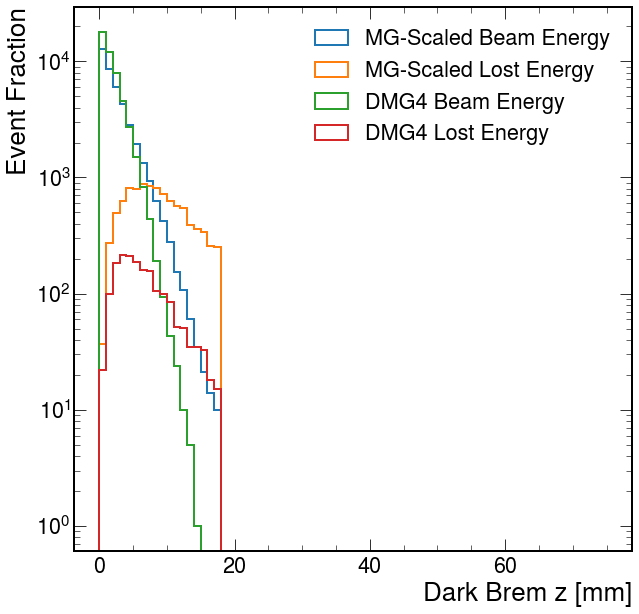

In [14]:
inc_e_cuts = {}
for name, df in el_data.items() :
    if name == 'MG' :
        continue
    inc_e_cuts[f'{name} Beam Energy'] = df[df['incident_energy']>=4000.]
    inc_e_cuts[f'{name} Lost Energy'] = df[df['incident_energy']< 4000.]

for name, sl in inc_e_cuts.items() :
    plt.hist(sl['z'],
             bins=75,range=(0.,75.),histtype='step',linewidth=2.,label=name)
plt.yscale('log')
plt.xlabel('Dark Brem z [mm]')
plt.ylabel('Event Fraction')
plt.legend()
plt.show()